# Reproducing Calvano et al. (2020)
## Baseline - Stat des - Price cycles
### Author: Andréa Epivent

In [2]:
# Import relevant packages
import os
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
# Set working directory
path = "/Users/admin/Desktop/PhD/RL_AlgorithmicCollusion"

In [4]:
# Import our custom functions
os.chdir(path+"/Functions")
from find_state import find_rowindex
from profitquantity import quantity_compute, profit_compute
from prices import get_last_price, get_forward_price
from detect_price_cycles import is_k_periodic, price_cycle, graph_cycle

# Import parameters
exec(open("parameters.py").read())

In [79]:
# Import data from training
q_table_1 = np.load(path+'/Output/Baseline/q_table_a1.npy')
q_table_2 = np.load(path+'/Output/Baseline/q_table_a2.npy')
q_info = np.load(path+'/Output/Baseline/q_info.npy')
A = np.load(path+'/Output/Baseline/actions.npy')
S = np.load(path+'/Output/Baseline/states.npy')
n_iterations = np.load(path+'/Output/Baseline/n_iterations.npy')
extra_profit = np.load(path+'/Output/Baseline/extra_profit.npy')
f_extra_profit = np.load(path+'/Output/Baseline/f_extra_profit.npy')

### Detect price cycles

* <b>Remark</b>: Stock next 40 price for both agents for each episode and keep last 20 prices. We do this because exploration can still occur towards end of episode, therefore it may take a few iterations for agents to converge to final strategies.

In [80]:
f_price1, f_price2 = get_forward_price(40,q_table_1,q_table_2,q_info,n_iterations,S,A)
f_price1 = f_price1[:,20:40]
f_price2 = f_price2[:,20:40]

* Check price cycle for both agents (Table 2)

In [7]:
cycles_a1 = price_cycle(f_price1,n_episodes)
cycles_a2 = price_cycle(f_price2,n_episodes)

In [8]:
# Agent 1
print(cycles_a1[cycles_a1==1].shape[0])
print(cycles_a1[cycles_a1==2].shape[0])
print(cycles_a1[cycles_a1>=3].shape[0])

49
29
22


In [9]:
# Agent 2
print(cycles_a2[cycles_a2==1].shape[0])
print(cycles_a2[cycles_a2==2].shape[0])
print(cycles_a2[cycles_a2>=3].shape[0])

48
30
22


In [10]:
# Max cycle length
print(max(cycles_a1))
print(max(cycles_a2))

8.0
8.0


### Check symmetry

* <b>Remark</b>: check symmetry in cycle length and in limit price (for cycle of length 1 only).

In [11]:
cycles = np.zeros((n_episodes,))
for j in range(n_episodes):
    if cycles_a1[j] == cycles_a2[j]:
        if cycles_a1[j] == 1:
            if f_price1[j][0] == f_price2[j][0]:
                cycles[j] = 1 # corresponds to "1-sym" case
            else:
                cycles[j] = 1.5 # corresponds to "1-asym" case
        else:
            cycles[j] = cycles_a1[j]
    else:
        cycles[j] = 99 # corresponds to "Hybrid" case

In [12]:
print(cycles[cycles==1].shape[0])
print(cycles[cycles==1.5].shape[0])
print(cycles[cycles==2].shape[0])
print(cycles[(cycles>=3)&(cycles<99)].shape[0])
print(cycles[cycles==99].shape[0])

21
24
26
22
7


In [37]:
# Save for later use
np.save(path+'/Output/Baseline/cycles', cycles)

### Graphs

* Visualize all price cycles (Figures 6, 10-13)

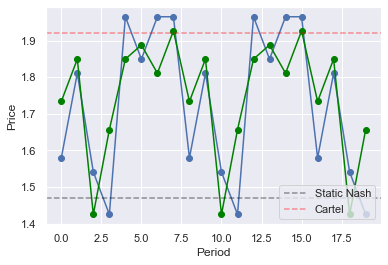

Cycle length: 8.0
Index: 0


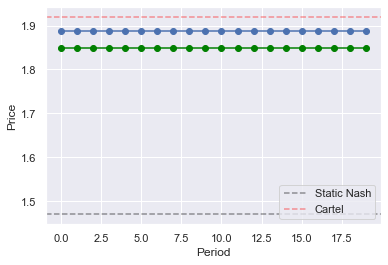

Cycle length: 1.5
Index: 1


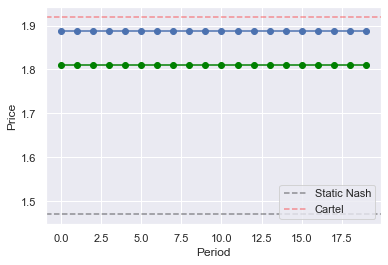

Cycle length: 1.5
Index: 2


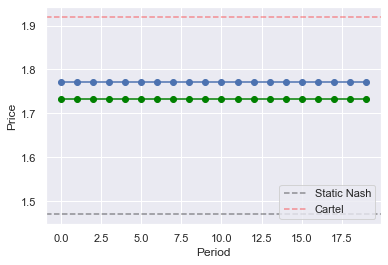

Cycle length: 1.5
Index: 3


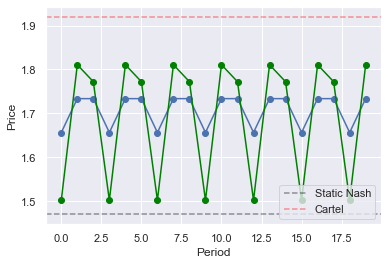

Cycle length: 3.0
Index: 4


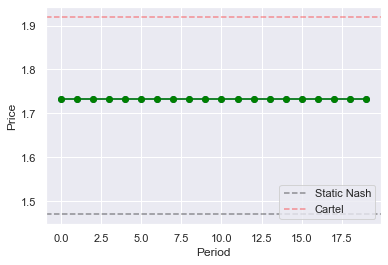

Cycle length: 1.0
Index: 5


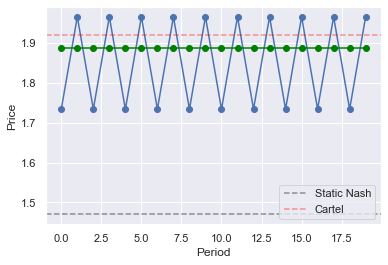

Cycle length: 99.0
Index: 6


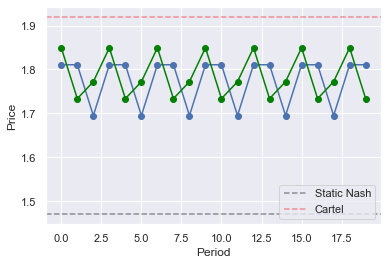

Cycle length: 3.0
Index: 7


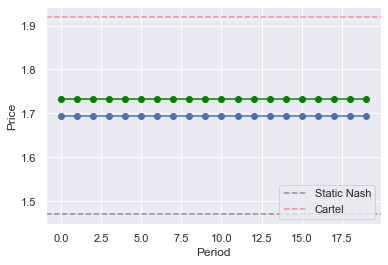

Cycle length: 1.5
Index: 8


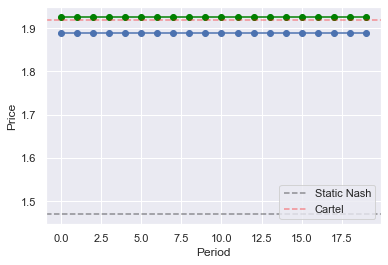

Cycle length: 1.5
Index: 9


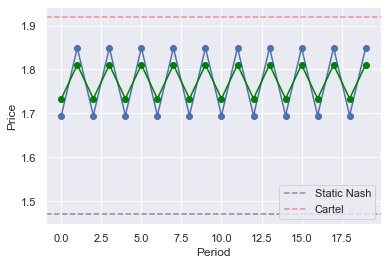

Cycle length: 2.0
Index: 10


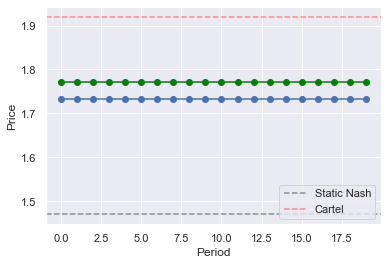

Cycle length: 1.5
Index: 11


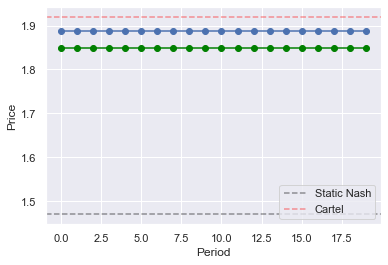

Cycle length: 1.5
Index: 12


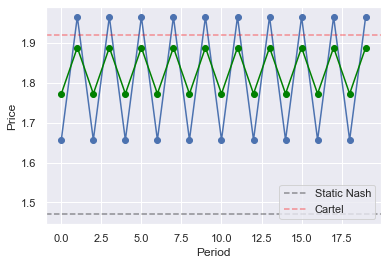

Cycle length: 2.0
Index: 13


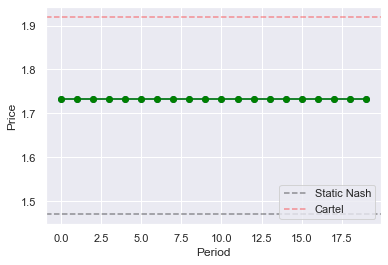

Cycle length: 1.0
Index: 14


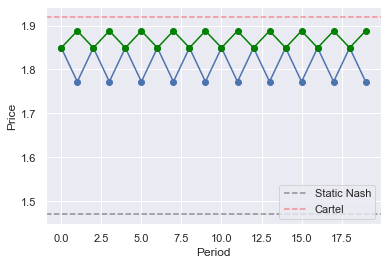

Cycle length: 2.0
Index: 15


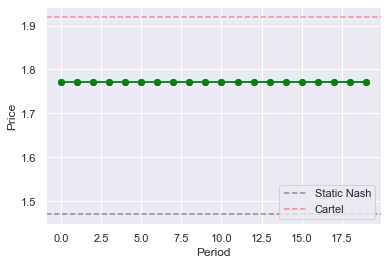

Cycle length: 1.0
Index: 16


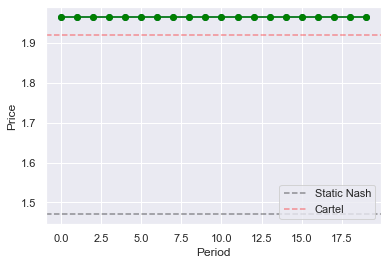

Cycle length: 1.0
Index: 17


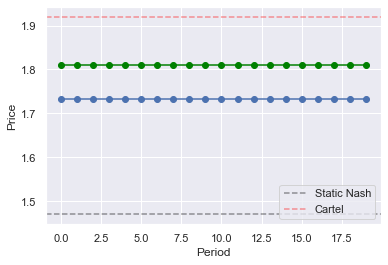

Cycle length: 1.5
Index: 18


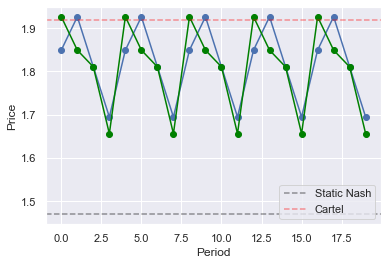

Cycle length: 4.0
Index: 19


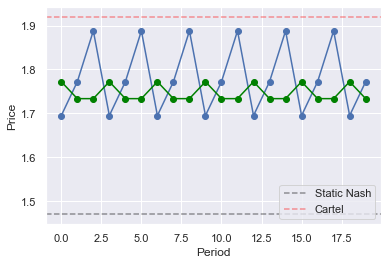

Cycle length: 3.0
Index: 20


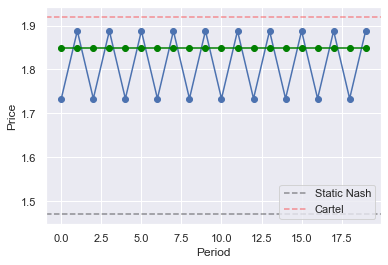

Cycle length: 99.0
Index: 21


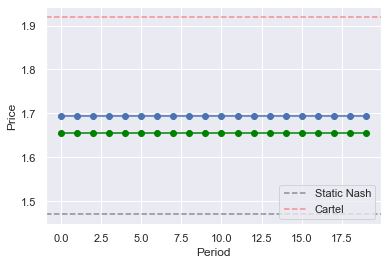

Cycle length: 1.5
Index: 22


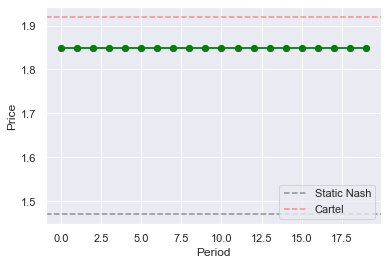

Cycle length: 1.0
Index: 23


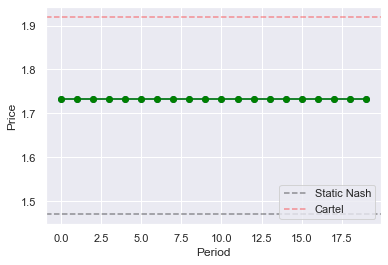

Cycle length: 1.0
Index: 24


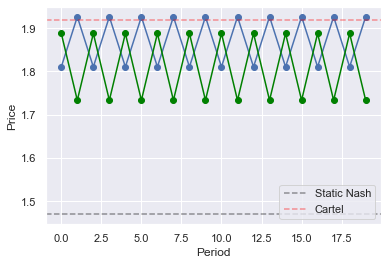

Cycle length: 2.0
Index: 25


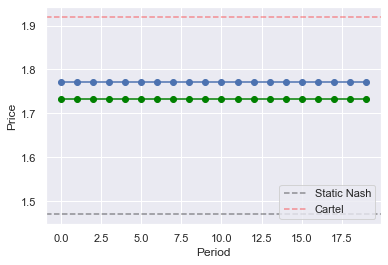

Cycle length: 1.5
Index: 26


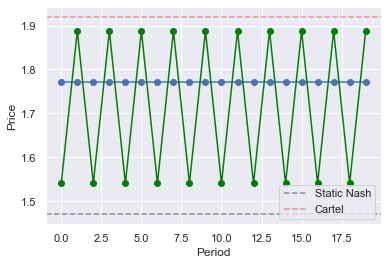

Cycle length: 99.0
Index: 27


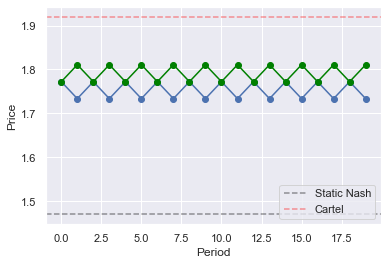

Cycle length: 2.0
Index: 28


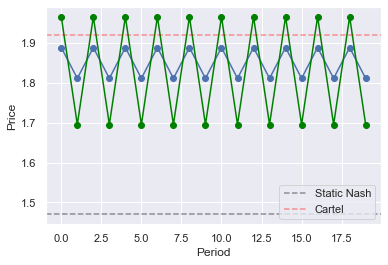

Cycle length: 2.0
Index: 29


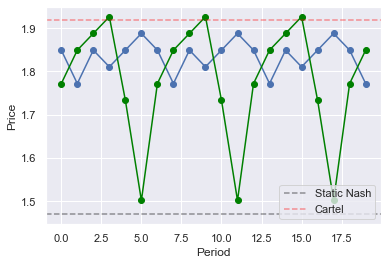

Cycle length: 6.0
Index: 30


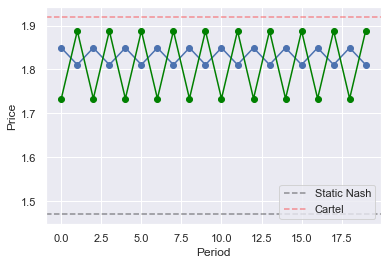

Cycle length: 2.0
Index: 31


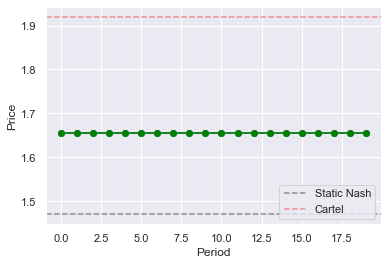

Cycle length: 1.0
Index: 32


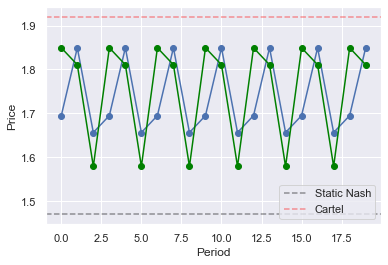

Cycle length: 3.0
Index: 33


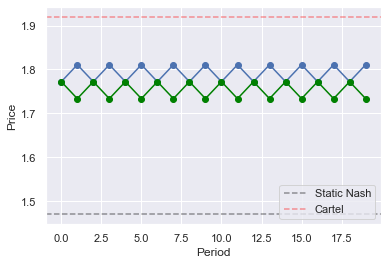

Cycle length: 2.0
Index: 34


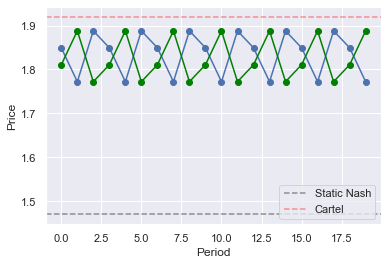

Cycle length: 3.0
Index: 35


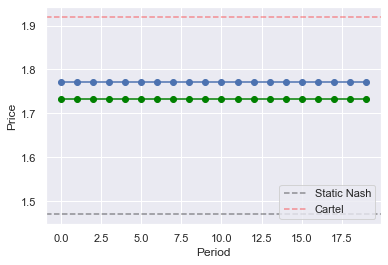

Cycle length: 1.5
Index: 36


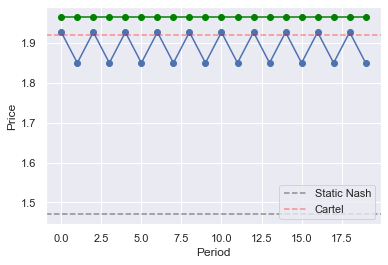

Cycle length: 99.0
Index: 37


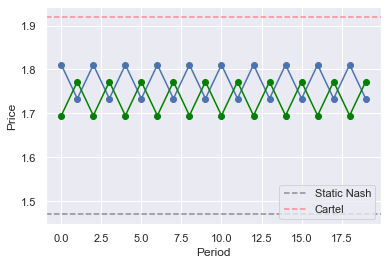

Cycle length: 2.0
Index: 38


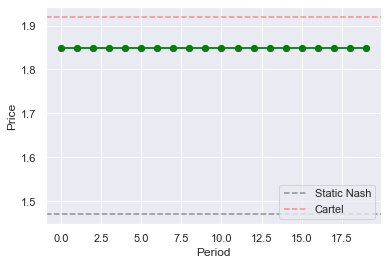

Cycle length: 1.0
Index: 39


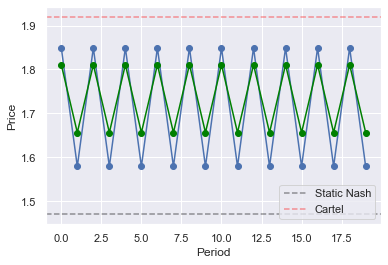

Cycle length: 2.0
Index: 40


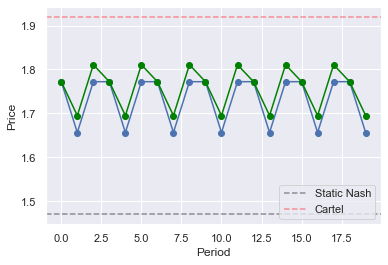

Cycle length: 3.0
Index: 41


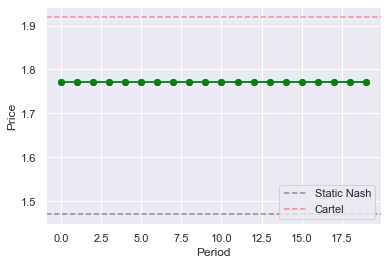

Cycle length: 1.0
Index: 42


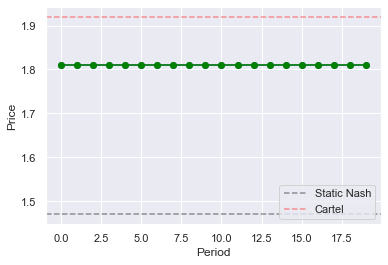

Cycle length: 1.0
Index: 43


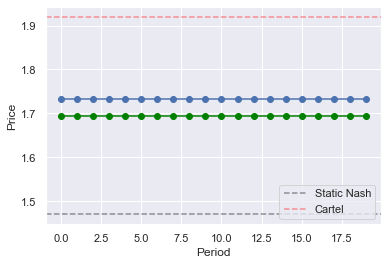

Cycle length: 1.5
Index: 44


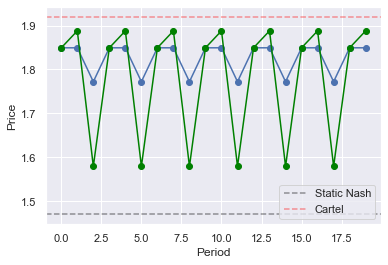

Cycle length: 3.0
Index: 45


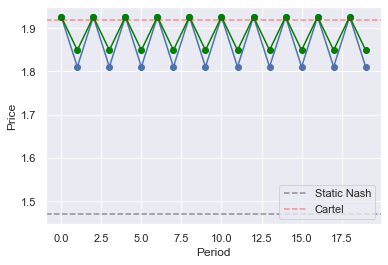

Cycle length: 2.0
Index: 46


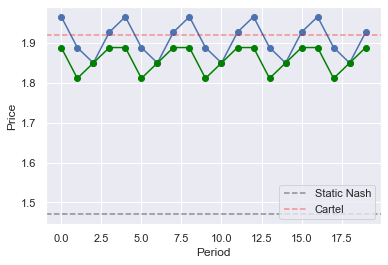

Cycle length: 4.0
Index: 47


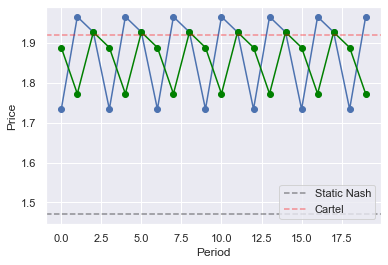

Cycle length: 3.0
Index: 48


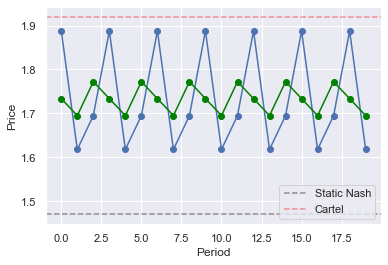

Cycle length: 3.0
Index: 49


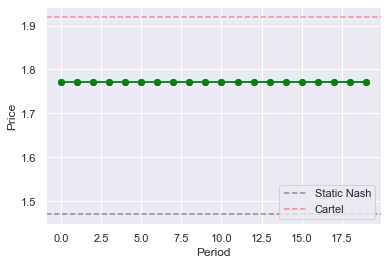

Cycle length: 1.0
Index: 50


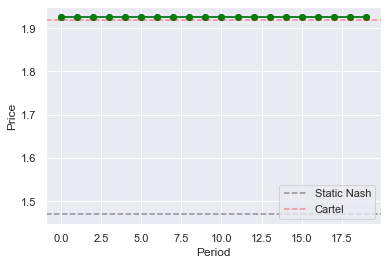

Cycle length: 1.0
Index: 51


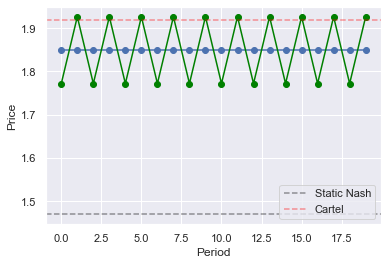

Cycle length: 99.0
Index: 52


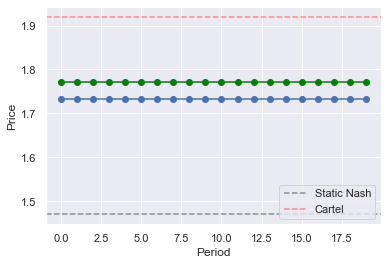

Cycle length: 1.5
Index: 53


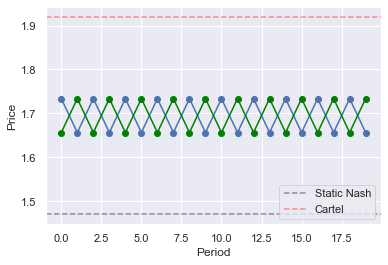

Cycle length: 2.0
Index: 54


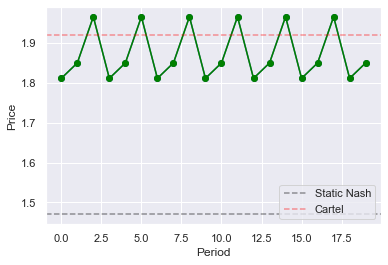

Cycle length: 3.0
Index: 55


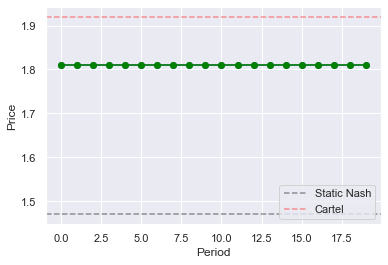

Cycle length: 1.0
Index: 56


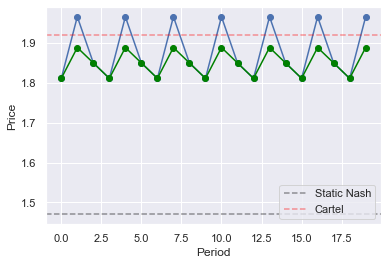

Cycle length: 3.0
Index: 57


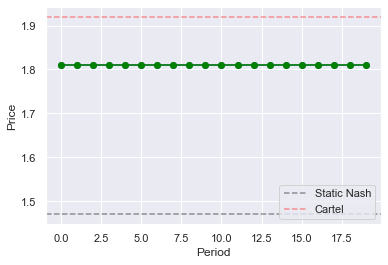

Cycle length: 1.0
Index: 58


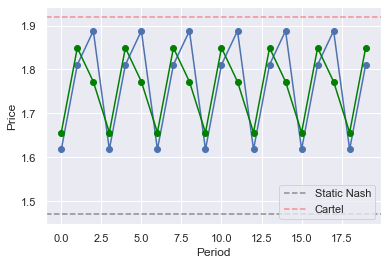

Cycle length: 3.0
Index: 59


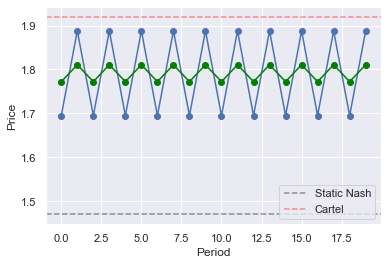

Cycle length: 2.0
Index: 60


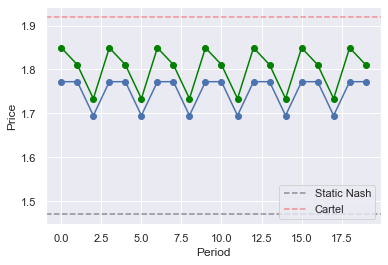

Cycle length: 3.0
Index: 61


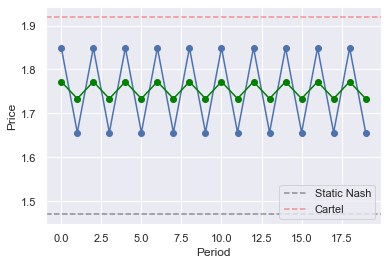

Cycle length: 2.0
Index: 62


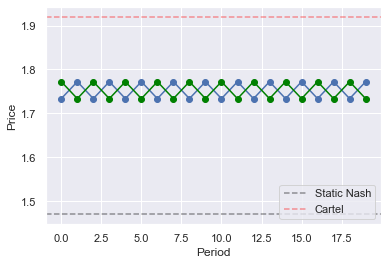

Cycle length: 2.0
Index: 63


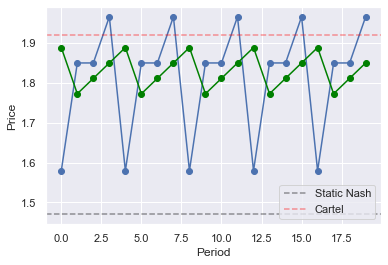

Cycle length: 4.0
Index: 64


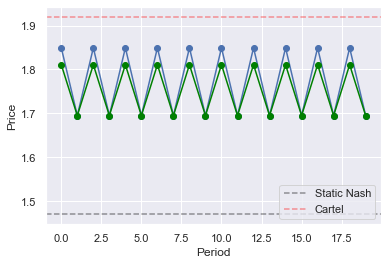

Cycle length: 2.0
Index: 65


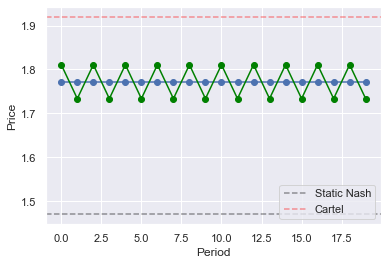

Cycle length: 99.0
Index: 66


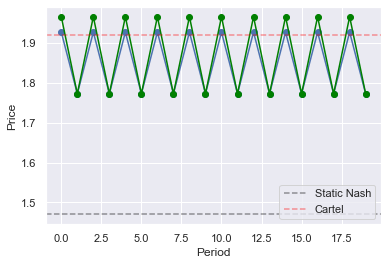

Cycle length: 2.0
Index: 67


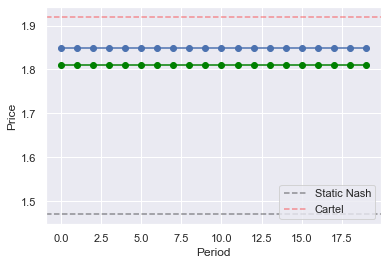

Cycle length: 1.5
Index: 68


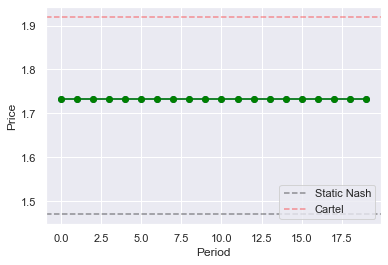

Cycle length: 1.0
Index: 69


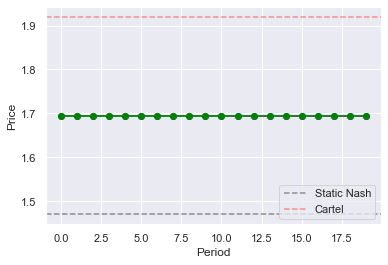

Cycle length: 1.0
Index: 70


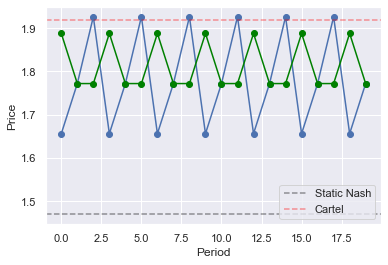

Cycle length: 3.0
Index: 71


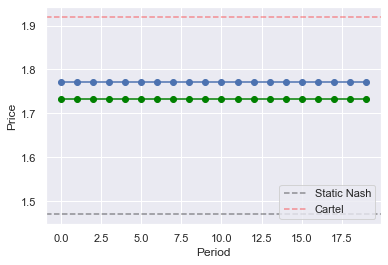

Cycle length: 1.5
Index: 72


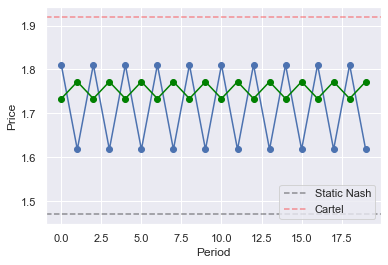

Cycle length: 2.0
Index: 73


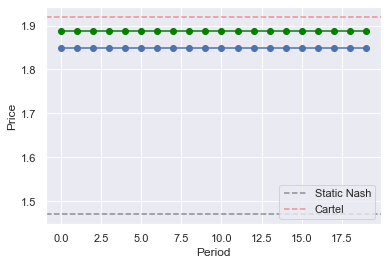

Cycle length: 1.5
Index: 74


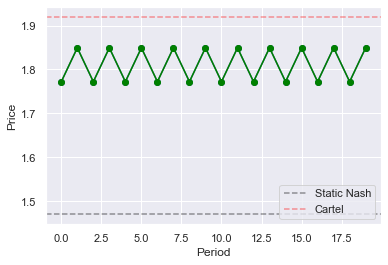

Cycle length: 2.0
Index: 75


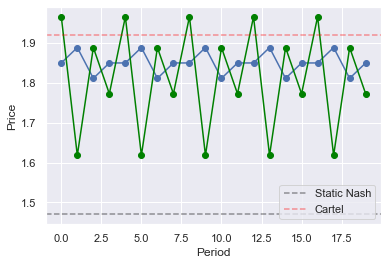

Cycle length: 4.0
Index: 76


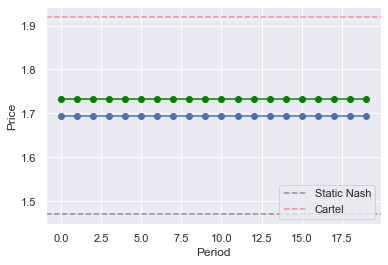

Cycle length: 1.5
Index: 77


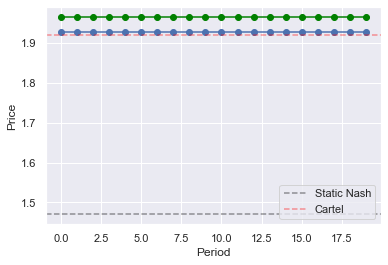

Cycle length: 1.5
Index: 78


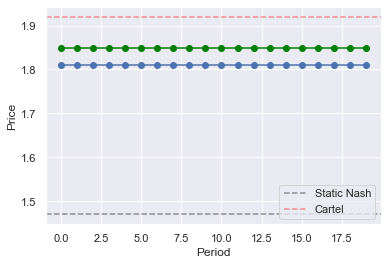

Cycle length: 1.5
Index: 79


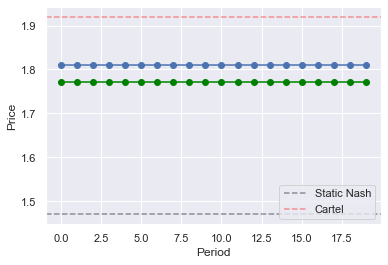

Cycle length: 1.5
Index: 80


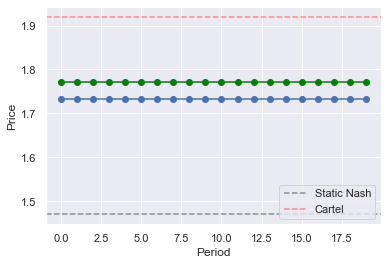

Cycle length: 1.5
Index: 81


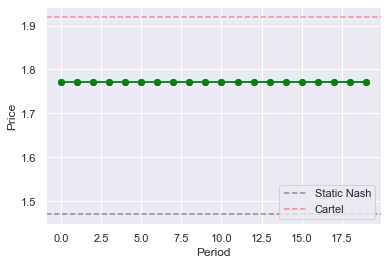

Cycle length: 1.0
Index: 82


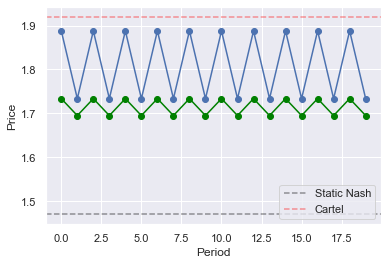

Cycle length: 2.0
Index: 83


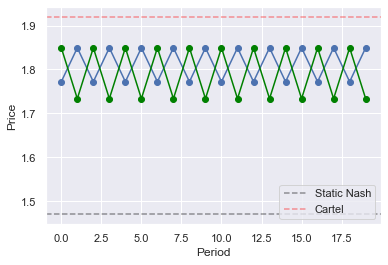

Cycle length: 2.0
Index: 84


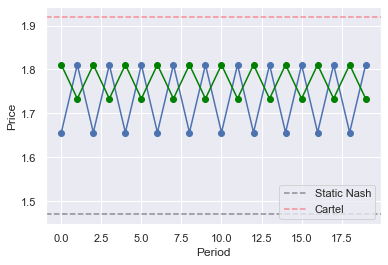

Cycle length: 2.0
Index: 85


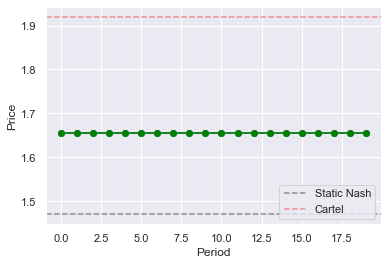

Cycle length: 1.0
Index: 86


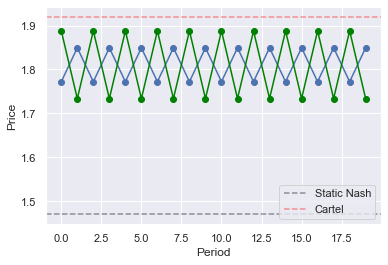

Cycle length: 2.0
Index: 87


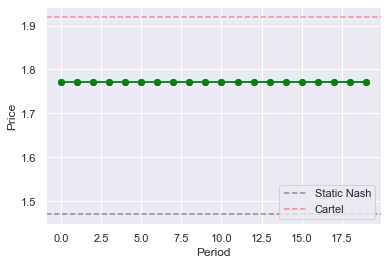

Cycle length: 1.0
Index: 88


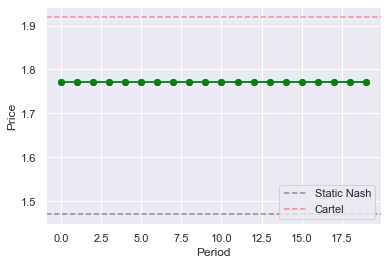

Cycle length: 1.0
Index: 89


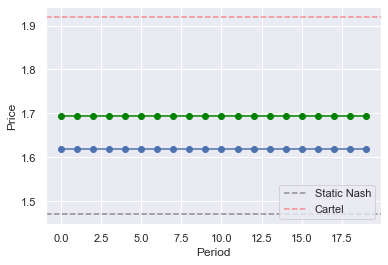

Cycle length: 1.5
Index: 90


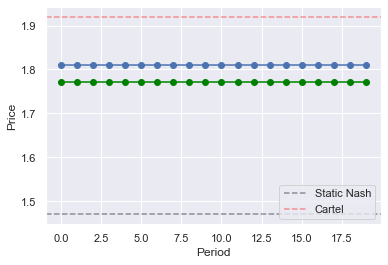

Cycle length: 1.5
Index: 91


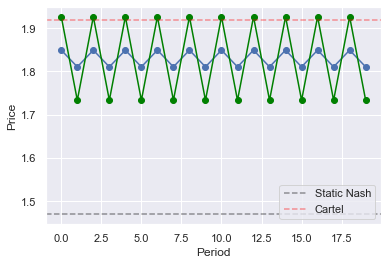

Cycle length: 2.0
Index: 92


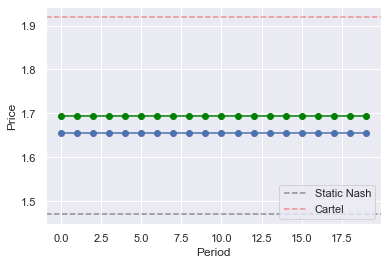

Cycle length: 1.5
Index: 93


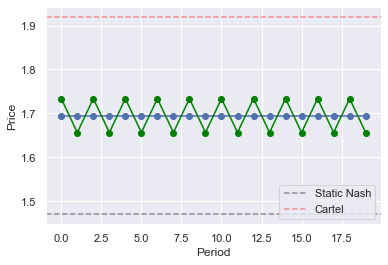

Cycle length: 99.0
Index: 94


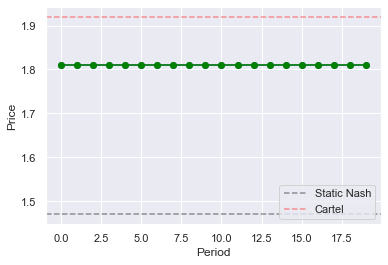

Cycle length: 1.0
Index: 95


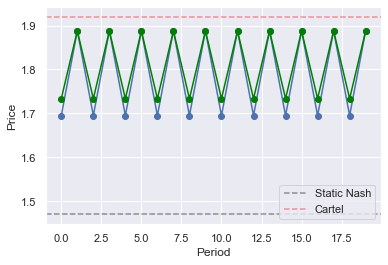

Cycle length: 2.0
Index: 96


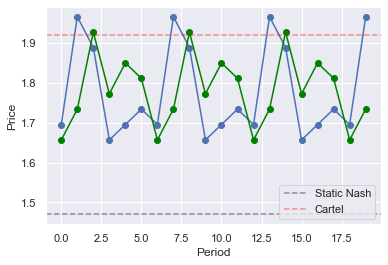

Cycle length: 6.0
Index: 97


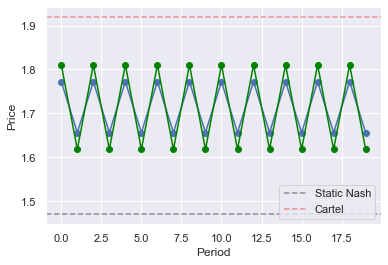

Cycle length: 2.0
Index: 98


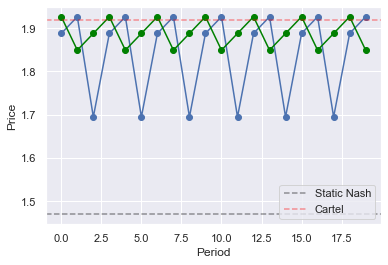

Cycle length: 3.0
Index: 99


In [38]:
for j in range(n_episodes):
    graph_cycle(f_price1[j],f_price2[j],p_N,p_M)
    print(f"Cycle length: {cycles[j]}")
    print(f"Index: {j}")

### Descriptive statistics per cycle length

* Processing

In [67]:
# Create cycle dataframe
df_cycle = pd.DataFrame(cycles,columns=["cycles"])

# Transform variable to string and deal with category
df_cycle.cycles = df_cycle.cycles.astype(int).astype(str)

# Create categories
df_cycle.cycles.replace("4","More",inplace=True)
df_cycle.cycles.replace("6","More",inplace=True)
df_cycle.cycles.replace("8","More",inplace=True)
df_cycle.cycles.replace("99","Hybrid",inplace=True)

df_cycle.cycles = pd.Categorical(df_cycle.cycles,
                                   categories=['1', '2', '3', 'More','Hybrid'],
                                   ordered=True)

In [68]:
# Concatenate with profits
df_extra_profit = pd.DataFrame(extra_profit,columns=["(Last) Extra profit"])
df_extra_profit["Forward mean extra profit"] = f_extra_profit

df_profitcycle = pd.concat([df_extra_profit,df_cycle],axis=1)

In [102]:
# Concatenate with prices
df_p1 = pd.DataFrame(get_last_price(1,q_info,n_iterations)[0],columns=["Final price"])
df_p1["Forward mean price"] = f_price1.mean(axis=1)
df_p1["agent"] = 1

df_p2 = pd.DataFrame(get_last_price(1,q_info,n_iterations)[1],columns=["Final price"])
df_p2["Forward mean price"] = f_price2.mean(axis=1)
df_p2["agent"] = 2

df_prices = pd.concat([df_p1,df_p2]).reset_index()

df_pricescycle = pd.concat([df_prices,pd.concat([df_cycle,df_cycle]).reset_index()],axis=1)

* Extra-profit

Figure 15 (based on final price)

Text(0, 0.5, '(Last) Extra profit')

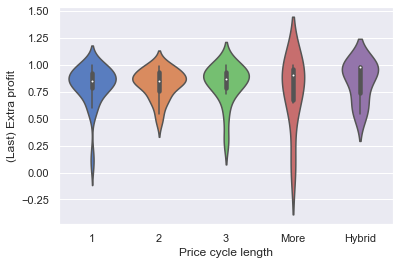

In [69]:
ax = sns.violinplot(x="cycles",y="(Last) Extra profit", data=df_profitcycle, palette="muted")
plt.xlabel('Price cycle length')
plt.ylabel('(Last) Extra profit')

Based on forward extra profit

Text(0, 0.5, 'Forward mean extra profit')

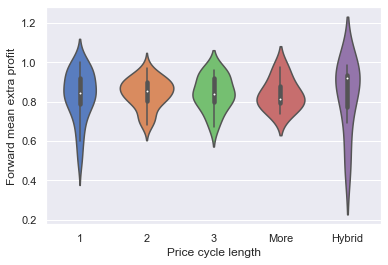

In [70]:
ax = sns.violinplot(x="cycles",y="Forward mean extra profit", data=df_profitcycle, palette="muted")
plt.xlabel('Price cycle length')
plt.ylabel('Forward mean extra profit')

Table 3

In [72]:
df_profitcycle

,(Last) Extra profit,Forward mean extra profit,cycles
0,0.062255,0.737449,More
1,0.977461,0.977461,1
2,0.952180,0.952180,1
3,0.822316,0.822316,1
4,0.291591,0.672554,3
...,...,...,...
95,0.921266,0.921266,1
96,0.991564,0.866395,2
97,0.706113,0.799578,More
98,0.543299,0.716459,2


In [75]:
print(df_profitcycle.groupby("cycles").mean())
print(df_profitcycle.groupby("cycles").std())
print(df_profitcycle["(Last) Extra profit"].mean())
print(df_profitcycle["(Last) Extra profit"].std())
print(df_profitcycle["Forward mean extra profit"].mean())
print(df_profitcycle["Forward mean extra profit"].std())

        (Last) Extra profit  Forward mean extra profit
cycles                                                
1                  0.807400                   0.829472
2                  0.821618                   0.843793
3                  0.821000                   0.843447
More               0.749676                   0.838969
Hybrid             0.848217                   0.828653
        (Last) Extra profit  Forward mean extra profit
cycles                                                
1                  0.191248                   0.128389
2                  0.135057                   0.074649
3                  0.185723                   0.086077
More               0.332316                   0.079375
Hybrid             0.184633                   0.182450
0.8119530259987552
0.18684865466135261
0.8358992572756666
0.11058242397997757


* Prices (Figure 14)

Text(0, 0.5, 'Price')

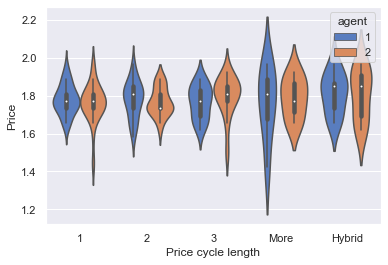

In [106]:
ax = sns.violinplot(x="cycles",y="Final price",hue="agent", data=df_pricescycle, palette="muted")
plt.xlabel('Price cycle length')
plt.ylabel('Price')

In [113]:
print(df_pricescycle.groupby("cycles").mean())
print(df_pricescycle.groupby("cycles").std())

            index  Final price  Forward mean price  agent      index
cycles                                                              
1       48.377778     1.770857            1.781143    1.5  48.377778
2       55.884615     1.774368            1.786978    1.5  55.884615
3       45.600000     1.782429            1.793229    1.5  45.600000
More    47.571429     1.774898            1.810577    1.5  47.571429
Hybrid  43.285714     1.807959            1.812092    1.5  43.285714
            index  Final price  Forward mean price     agent      index
cycles                                                                 
1       30.816812     0.091870            0.076501  0.502801  30.816812
2       27.181780     0.085198            0.049001  0.504878  27.181780
3       23.950524     0.096592            0.055704  0.508548  23.950524
More    32.604186     0.146262            0.046233  0.518875  32.604186
Hybrid  28.703869     0.118610            0.079504  0.518875  28.703869
